In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/home/ebrahim/Downloads/spark-3.0.1-bin-hadoop3.2"

In [2]:
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [3]:
import json
import os
import findspark
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
import seaborn as sns

findspark.init()
os.environ["PYSPARK_DRIVER_PYTHON"] = os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.7"


In [4]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StopWordsRemover

In [5]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Read all profiles

In [6]:
profiles_df = spark.read.parquet('./translated/gsheet/*.parquet').withColumn(
    "translated_description",
    F.regexp_replace(F.col("translated_description"), r"\.|\'|\"|\[|\]|\,|\-|\+|\(|\)|\`|\*|\^", " ")
).withColumn(
    "translated_description",
    F.regexp_replace(F.col("translated_description"), r"\s+", " ")
).withColumn(
    "translated_description",
    F.lower("translated_description"),
).withColumn(
    "status",
    F.when(
        F.col("status").startswith("wi"),
        F.lit("widowed"),
    ).when(
        F.col("status").startswith("di"),
        F.lit("divorced"),
    ).when(
        F.col("status").startswith("sep"),
        F.lit("separated"),
    ).when(
        F.col("status").startswith("married"),
        F.lit("married"),
    ).when(
        F.col("status") == "in relationship",
        F.col("status"),
    ).when(
        F.col("status").startswith("sing"),
        F.lit("single"),
    ).otherwise(F.lit("other")),
).select(
    F.col("age").cast(T.IntegerType()).alias("age"),
    F.col("ethnicity"),
    F.when(F.col("gender") == "male", F.lit(0)).otherwise(F.lit(1)).alias("gender"),
    F.col("scam"),
    F.col("status"),
    F.col("translated_description").alias("description")
)

In [7]:
profiles_df.groupBy("scam").count().show(3)

+----+-----+
|scam|count|
+----+-----+
|   0|36276|
|   1| 7987|
+----+-----+



### Correlation between independent cols

In [8]:
indexer = StringIndexer(inputCols=["ethnicity", "status"], outputCols=["ethnicity_index", "status_index"])

In [9]:
indexed = indexer.setHandleInvalid("skip").fit(profiles_df.drop("scam")).transform(profiles_df.drop("scam"))

In [10]:
corr = indexed.toPandas().corr()

In [11]:
corr

,age,gender,ethnicity_index,status_index
age,1.000000,-0.158107,-0.113374,0.351142
gender,-0.158107,1.000000,0.021581,-0.077619
ethnicity_index,-0.113374,0.021581,1.000000,-0.042973
status_index,0.351142,-0.077619,-0.042973,1.000000


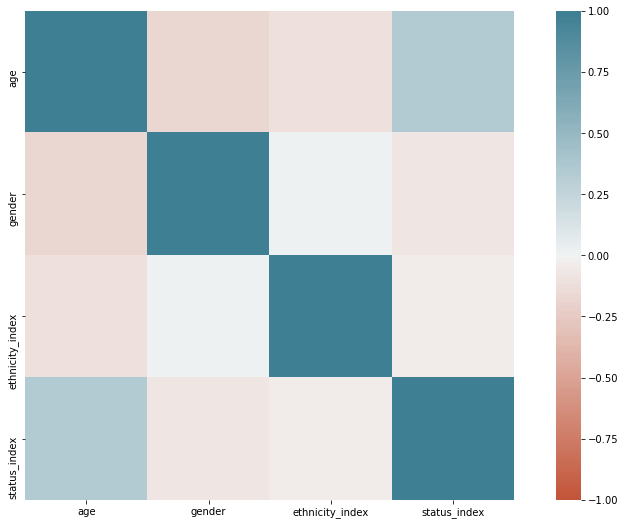

In [12]:
fig, ax = plt.subplots(figsize=(15, 9)) 

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

> Lets pick all of them

### Logistic regression

In [13]:
stages = []
categoral_cols = ["ethnicity", "status"]

num_cols = ["age", "gender",]

In [14]:
for categoricalCol in categoral_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index').setHandleInvalid("skip")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]


> Normal cols

In [15]:
tokenizer = Tokenizer(inputCol="description", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

cv = CountVectorizer(vocabSize=2**16, inputCol="filtered", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="idf_features", minDocFreq=5) #minDocFreq: remove sparse terms

stages.append(tokenizer)
stages.append(remover)
stages.append(cv)
stages.append(idf)

In [16]:
label_stringIdx = StringIndexer(inputCol = 'scam', outputCol = 'label').setHandleInvalid("skip")

stages.append(label_stringIdx)

assemblerInputs = [c + "classVec" for c in categoral_cols] + num_cols + ["idf_features"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features").setHandleInvalid("skip")

stages.append(assembler)


In [17]:
profiles_df.withColumn("description", F.when(F.col("description").isNull(), F.lit("")).otherwise(F.col("description")))

DataFrame[age: int, ethnicity: string, gender: int, scam: bigint, status: string, description: string]

In [18]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(profiles_df.withColumn("description", F.when(F.col("description").isNull(), F.lit("")).otherwise(F.col("description"))))
df = pipelineModel.transform(profiles_df.withColumn("description", F.when(F.col("description").isNull(), F.lit("")).otherwise(F.col("description"))))
df = df.drop("ethnicityIndex", "ethnicityclassVec", "statusclassVec", "words", "statusIndex", "tf", "idf", "filtered", "cv", "idf_features")
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: integer (nullable = false)
 |-- scam: long (nullable = true)
 |-- status: string (nullable = true)
 |-- description: string (nullable = true)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [19]:
train, test = df.randomSplit([0.7, 0.3], seed = 2000)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


Training Dataset Count: 29761
Test Dataset Count: 12704


In [20]:
train.groupBy("scam").count().show(20)

+----+-----+
|scam|count|
+----+-----+
|   0|25075|
|   1| 4686|
+----+-----+



In [21]:
test.groupBy("scam").count().show(20)

+----+-----+
|scam|count|
+----+-----+
|   0|10754|
|   1| 1950|
+----+-----+



In [23]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
lrModel = lr.fit(train)

In [24]:
predictions = lrModel.transform(test)
predictions.show(2)

+---+---------+------+----+------+-----------+-----+--------------------+--------------------+--------------------+----------+
|age|ethnicity|gender|scam|status|description|label|            features|       rawPrediction|         probability|prediction|
+---+---------+------+----+------+-----------+-----+--------------------+--------------------+--------------------+----------+
| 19|    asian|     1|   0|single|           |  0.0|(18304,[4,12,18,1...|[4.32864819825129...|[0.98698623177156...|       0.0|
| 19|    asian|     1|   0|single|           |  0.0|(18304,[4,12,18,1...|[4.32864819825129...|[0.98698623177156...|       0.0|
+---+---------+------+----+------+-----------+-----+--------------------+--------------------+--------------------+----------+
only showing top 2 rows



In [25]:
evaluator = BinaryClassificationEvaluator()
print('Accuracy', evaluator.evaluate(predictions))

Accuracy 0.9652153521885705


In [ ]:
spark.stop()